In [242]:
import tensorflow as tf
import os

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
data_dir = '/content/drive/MyDrive/data'

# **PREPROCESSING**

In [15]:
# To remove corrupted files before preprocessing
import cv2
import imghdr

In [16]:
img_extension = ['jpeg','jpg','png','bmp']

In [17]:
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir,image_class)):
    image_path = os.path.join(data_dir,image_class,image)
    try:
      # remove files that are too small
      if os.path.getsize(image_path)<7000:
        print ('Corrupted file : {}'.format(image_path))
        os.remove(image_path)
      # remove files if they cannot load in opencv
      img=cv2.imread(image_path)
      # remove files with mismatched extensions
      extension = imghdr.what(image_path)
      if extension not in img_extension:
        print('Image not in extensions list : {}'.format(image_path))
        os.remove(image_path)

    except Exception as e:
        print('Issue with image : {}'.format(image_path))

Image not in extensions list : /content/drive/MyDrive/data/happy/427394C200000578-0-image-a-24_1500384481554.jpg
Image not in extensions list : /content/drive/MyDrive/data/happy/2560px-Happy_People.jpg
Image not in extensions list : /content/drive/MyDrive/data/happy/Habits-of-Financially-Happy-People.jpg
Image not in extensions list : /content/drive/MyDrive/data/happy/guilherme-stecanella-375176-unsplash.jpg
Corrupted file : /content/drive/MyDrive/data/happy/AGvuzYYKwpVKx2twV8WlJvb57J1s9vl8q8zdOZ6qmYyOs64-c-mo.jpg
Issue with image : /content/drive/MyDrive/data/happy/AGvuzYYKwpVKx2twV8WlJvb57J1s9vl8q8zdOZ6qmYyOs64-c-mo.jpg
Corrupted file : /content/drive/MyDrive/data/happy/image12.jpeg
Issue with image : /content/drive/MyDrive/data/happy/image12.jpeg
Corrupted file : /content/drive/MyDrive/data/happy/image11.jpeg
Issue with image : /content/drive/MyDrive/data/happy/image11.jpeg
Corrupted file : /content/drive/MyDrive/data/happy/image10.jpeg
Issue with image : /content/drive/MyDrive/data

In [18]:
tf.data.Dataset

tensorflow.python.data.ops.dataset_ops.DatasetV2

In [19]:
import numpy as np
from matplotlib import pyplot as plt

In [20]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 210 files belonging to 2 classes.


In [21]:
data_iterator = data.as_numpy_iterator()

In [31]:
# Images as numpy arrays
batch = data_iterator.next()
batch[0].shape

(32, 256, 256, 3)

In [36]:
# Label 0 : Happy
# Label 1 : Sad
batch[1]

array([0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 0], dtype=int32)

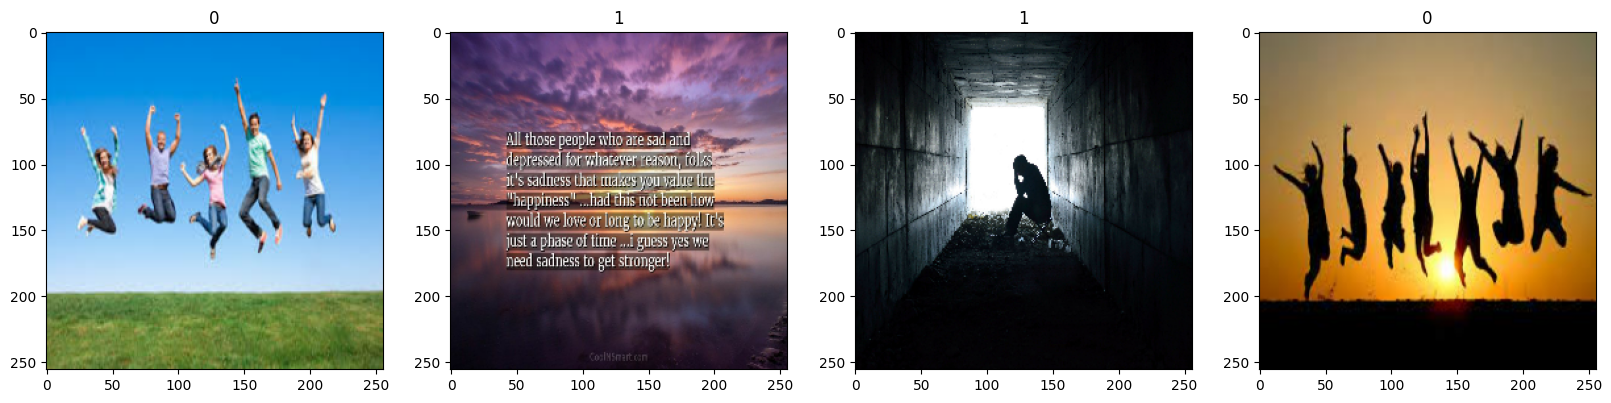

In [37]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

In [70]:
# Scaling through API mapping
data = data.map(lambda x,y:(x/255,y))

In [71]:
scaled_iterator = data.as_numpy_iterator()

In [117]:
batch = scaled_iterator.next()

In [118]:
batch[0].max()

1.0

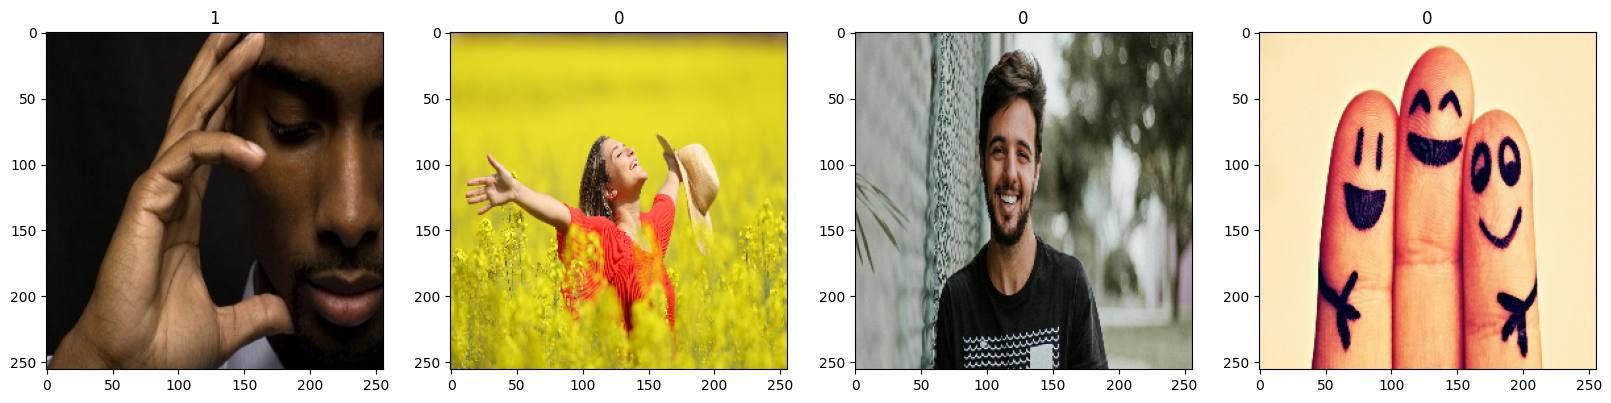

In [119]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(batch[1][idx])

## **CNN 2D Model**

In [120]:
len(data)

7

In [159]:
train_size = round(len(data)*.7)
val_size = round(len(data)*.2)
test_size = round(len(data)*.1)

In [160]:
train_size + val_size + test_size

7

In [161]:
# Splitting data
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [162]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D,MaxPooling2D, Dense, Flatten

In [163]:
model=Sequential()

In [164]:
# Building Neural Networks
model.add(Conv2D(16,(3,3),1, activation = 'relu', input_shape= (256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),1, activation = 'relu', input_shape= (256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),1, activation = 'relu', input_shape= (256,256,3)))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [165]:
model.compile('Adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [166]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 60, 60, 16)        4624      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 30, 30, 16)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 14400)            

# **TRAINING**

In [167]:
logdir='/content/drive/MyDrive/log'

In [168]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [169]:
info = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
5/5 [==============================] - 28s 5s/step - loss: 0.7319 - accuracy: 0.6062 - val_loss: 0.5947 - val_accuracy: 0.8438
Epoch 2/20
5/5 [==============================] - 23s 4s/step - loss: 0.5513 - accuracy: 0.6812 - val_loss: 0.7411 - val_accuracy: 0.5312
Epoch 3/20
5/5 [==============================] - 22s 4s/step - loss: 0.5418 - accuracy: 0.6875 - val_loss: 0.4856 - val_accuracy: 0.8125
Epoch 4/20
5/5 [==============================] - 22s 4s/step - loss: 0.4710 - accuracy: 0.7750 - val_loss: 0.3568 - val_accuracy: 0.9062
Epoch 5/20
5/5 [==============================] - 26s 5s/step - loss: 0.3458 - accuracy: 0.8625 - val_loss: 0.4544 - val_accuracy: 0.8438
Epoch 6/20
5/5 [==============================] - 21s 3s/step - loss: 0.2612 - accuracy: 0.9187 - val_loss: 0.1698 - val_accuracy: 0.9375
Epoch 7/20
5/5 [==============================] - 26s 5s/step - loss: 0.1682 - accuracy: 0.9563 - val_loss: 0.0997 - val_accuracy: 0.9688
Epoch 8/20
5/5 [==================

In [170]:
info.history

{'loss': [0.7318912744522095,
  0.5513126254081726,
  0.5418273210525513,
  0.4709707200527191,
  0.3458467423915863,
  0.26119521260261536,
  0.1682385802268982,
  0.12588384747505188,
  0.058184392750263214,
  0.05452512949705124,
  0.027259737253189087,
  0.01822364516556263,
  0.013987153768539429,
  0.00435658497735858,
  0.008094037882983685,
  0.004879995249211788,
  0.005858621560037136,
  0.003293219255283475,
  0.0038936533965170383,
  0.003984256647527218],
 'accuracy': [0.606249988079071,
  0.6812499761581421,
  0.6875,
  0.7749999761581421,
  0.862500011920929,
  0.918749988079071,
  0.956250011920929,
  0.96875,
  0.987500011920929,
  0.987500011920929,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'val_loss': [0.5946916341781616,
  0.741095781326294,
  0.4855758547782898,
  0.3567596673965454,
  0.4543609023094177,
  0.16979089379310608,
  0.09968678653240204,
  0.021325331181287766,
  0.13386410474777222,
  0.016625359654426575,
  0.03886123374

# **PLOTS**

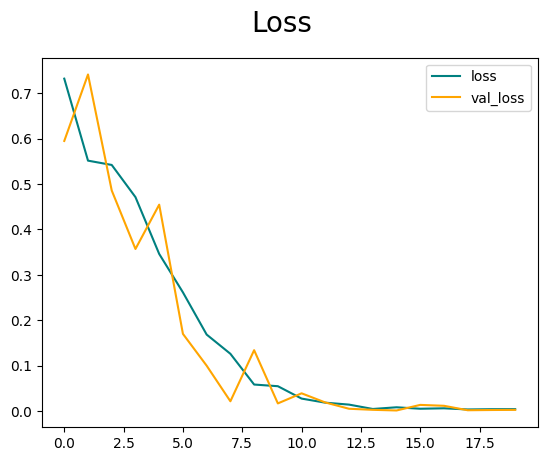

In [171]:
fig = plt.figure()
plt.plot(info.history['loss'], color='teal', label='loss')
plt.plot(info.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right")
plt.show()

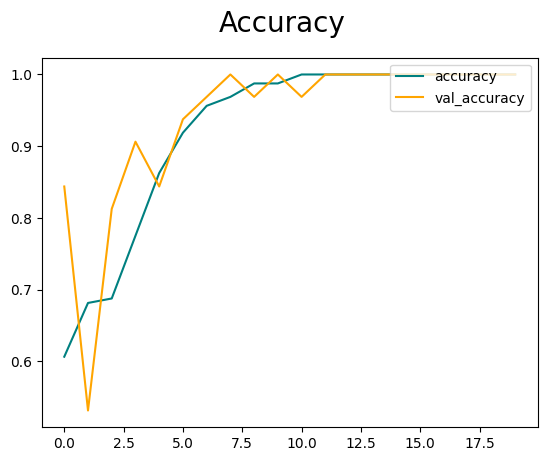

In [172]:
fig = plt.figure()
plt.plot(info.history['accuracy'], color='teal', label='accuracy')
plt.plot(info.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper right")
plt.show()

# **TESTING**

In [175]:
from tensorflow.python.keras.metrics import Precision, Recall, BinaryAccuracy

In [176]:
pre = Precision()
re= Recall()
bin= BinaryAccuracy()

In [177]:
len(test)

1

In [178]:
for batch in test.as_numpy_iterator():
  x,y = batch
  pred = model.predict(x)
  pre.update_state(y,pred)
  re.update_state(y,pred)
  bin.update_state(y,pred)

In [179]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {bin.result().numpy()}')

Precision: 1.0, Recall: 1.0, Accuracy: 1.0


In [213]:
happy_path='/content/drive/MyDrive/data/happpy.jpg'
sad_path='/content/drive/MyDrive/data/saddd.jpg'

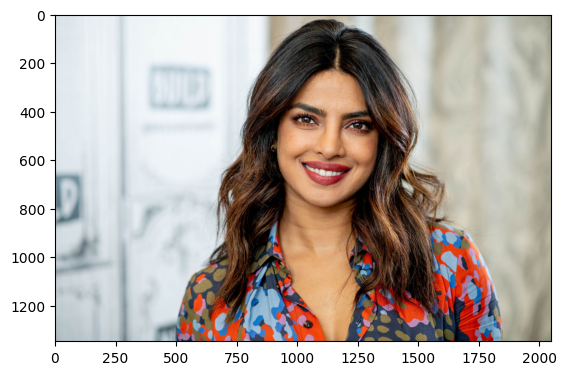

In [214]:
img = cv2.imread(happy_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

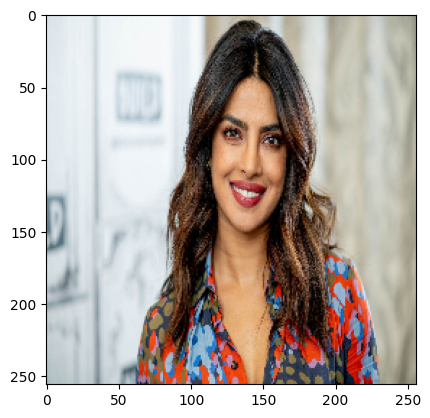

In [215]:
resize = tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [216]:
resize.shape

TensorShape([256, 256, 3])

In [217]:
np.expand_dims(resize,0).shape

(1, 256, 256, 3)

In [218]:
pred = model.predict(np.expand_dims(resize/255,0))

In [219]:
if pred<0.5:
  print(f'Image is predicted to be happy')
else:
  print(f'Image is predicted to be sad')

Image is predicted to be happy


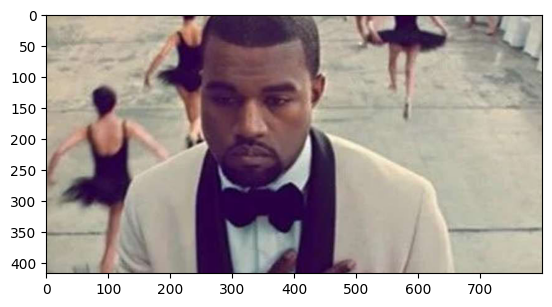

In [227]:
img = cv2.imread(sad_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

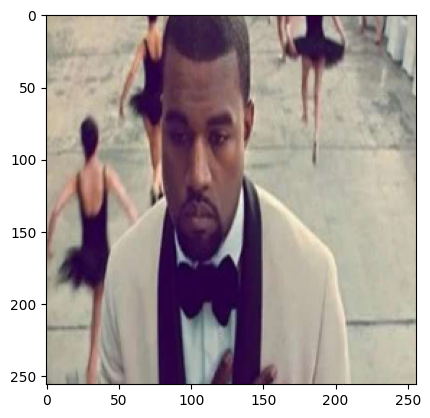

In [228]:
resize = tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [229]:
pred = model.predict(np.expand_dims(resize/255,0))

In [230]:
if pred<0.5:
  print(f'Image is predicted to be happy')
else:
  print(f'Image is predicted to be sad')

Image is predicted to be sad
